# Collect and Analyze a Twitter Network
[Effrosyni Simou](http://lts4.epfl.ch/simou), *PhD Student*, [EPFL](http://epfl.ch) [LTS4](http://lts4.epfl.ch)

# Objective of Exercise
The aim of this exercise is to learn how to create your own, real network using data collected from the Internet and then to discover some properties of the collected network. 

# Resources
You might want to have a look at the following resources before starting:

* [Twitter REST API](https://dev.twitter.com/rest/public)
* [Tweepy Documentation](http://tweepy.readthedocs.io/en/v3.5.0/)
* [Tutorial "Mining Twitter data with Python"](https://marcobonzanini.com/2015/03/02/mining-twitter-data-with-python-part-1/)

# 1. Collect a Twitter Network

In order to collect data from Twitter you will need to generate access tokens.  To do this you will need to register a [client application with Twitter](https://apps.twitter.com/). Once you are done you should have your tokens. You can now create a `credentials.ini` file as follows:
```
[twitter]
consumer_key = YOUR-CONSUMER-KEY
consumer_secret = YOUR-CONSUMER-SECRET
access_token = YOUR-ACCESS-TOKEN
access_secret = YOUR-ACCESS-SECRET
```
In this way you will have this information readily available to you. 

In [523]:
%matplotlib inline

import random
import configparser
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
import tweepy  # you will need to install tweepy first
# We want to visualize the network we create, to do so we will use networkx
import networkx as nx # WARNING: Library not included in the standard notebook

In [524]:
# Variable used to print degug information in this notebook
DEBUG_INFO = True

In [525]:
# Read the confidential token.
credentials = configparser.ConfigParser()
credentials.read('credentials.ini')

#authentication
auth = tweepy.OAuthHandler(credentials.get('twitter', 'consumer_key'), credentials.get('twitter', 'consumer_secret'))
auth.set_access_token(credentials.get('twitter', 'access_token'), credentials.get('twitter', 'access_secret'))

#construct API instance
#deal with rate limits and notify when delayed because of rate limits
api = tweepy.API(auth,wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

Now you are all set up to start collecting data from Twitter! 

In this exercise we will construct a network with the following logic:

1) We will chose a `user_id` in Twitter to be our first node. 

2) We will find (some) of the users who are both following `user_id` and are being followed by `user_id`. From now on we will call such users "connections" of `user_id`. We will place these user ids in a list called `first_nodes`. 

3) For every node in the list `first_nodes` we will then find (some) of the users who are following and are being followed by this node (aka the connections of this node). The user ids collected in this step will be placed in a list called `second_nodes`.

4) The collection of the ids of all nodes (aka Twitter users) that we have collected so far will be placed in a list called `all_nodes`.

5) Since we have only collected a subset of all possible "connections" for our nodes we have to check if there are any remaining inner connections that we have missed.

The entire network is to be organized in a dictionary with entries that will have as key the Twitter id of the user (this is a number characterizing each user in Twitter) and as value the list of ids of his connections.

So, let us begin. The first thing that you will have to do is to chose the node from which everything will start. I have chosen the Twitter account of [Applied Machine Learning Days](https://www.appliedmldays.org) that will take place in January 2018 in EPFL. You may change that if you wish to, but please make sure that the user you chose has both followers and friends and that he allows you to access this data.

In [526]:
user = 'msf'
user_id=api.get_user(user).id

In the following cell write a function that takes as an argument the Twitter id of a user and returns a list with the **ids** of his connections. Take into account the case where a user does not allow you to access this information.

**Reminder:** By connections we mean users that are both followers and friends of a given user.

In [527]:
def find_connections(user_id,nbr_of_pages=1):
    followers = []
    friends=[]
    try:
        for part_friends in tweepy.Cursor(api.friends_ids, id=user_id).pages(nbr_of_pages):
            friends.extend(part_friends)
        for part_followers in tweepy.Cursor(api.followers_ids, id=user_id).pages(nbr_of_pages):
            followers.extend(part_followers)
    except tweepy.TweepError as e:
        # Manage errors from the tweepy API. We simply print the error information
        print("Error while finding connections!\n\tReason:",
              "{}\n\tResponse: {}\n\tAPI Code: {}".format(e.reason, e.response, e.api_code))
        return None 
    else:
        connections = np.intersect1d(friends, followers)
        # Print some debug information related to the s
        if DEBUG_INFO:
            print("{} has {} connections from {} friends and {} followers when using {} pages".format(
                user_id, len(connections), len(friends), len(followers), nbr_of_pages)
                 )
        return connections

In [528]:
# Change the value of nbr_of_pages to obtain more friends_ids and followers_ids
# Warning : If the page number is too high, we will run into rate limitation!
# Note: If this nbr_of_pages is not high enough, we might miss connections in
#       in the subsequent checks. Though, this will only happen for very large
#       following (1 page = 5000 followers). We accept this tradeoff to actually
#       get data in a reasonable time
nbr_of_pages=10
first_connections=find_connections(user_id,nbr_of_pages)
print('{}has {} connections'.format(user, len(first_connections)))
    

2195671183 has 112 connections from 1215 friends and 50000 followers when using 10 pages
msfhas 112 connections


In [529]:
print(first_connections)

[           8220122           11351772           15719971
           16834046           19177501           20433037
           20504947           20588986           20838866
           21303235           21835209           24908307
           25999480           26786894           31809636
           39219494           39483072           43075399
           51978298           61638283           73149690
           73617824           77485114           97219875
          105862849          109589216          111664235
          113398253          117180358          131896078
          138505765          191821461          215966785
          227459248          230169472          243851678
          247445228          252555813          260160888
          260288018          278992923          300759553
          305426621          375787968          391380430
          394103111          394326921          406433649
          459236731          488570234          529350142
          5559

Collect your `first_nodes` and `second_nodes` and organize your collected nodes and their connections in the dictionary called `network`.

Hints:
* Use `random.choice([1,3,4])` to randomly choose a number in `[1, 3, 4]`.
* Use the `append` and `remove` methods to add and remove an element from a Python list.
* The `pop` method removes the last item in the list.

In [530]:
network={}
 # Keep track of every connections and not only the ones in the network
 # This is a big optimization with regard to twitter api calls   
connections_dict={}
first_nodes=[]
second_nodes=[]
how_many=12 #This is the number of connections you are sampling. 
            #Keep small (e.g.3) for development, larger later (e.g. 10)
first_nodes=np.random.choice(first_connections, size=how_many,replace=False)

**Be careful!** You should only keep a small value for the `how_many` parameter while you are developing your code. In order to answer to the questions you should raise the value of this parameter to `how_many=10` at least. This will take a while to execute because of the API rate limit (plan your time accordingly). You should also remember to submit your jupyter notebook with the **output shown for a large value of the `how_many` parameter**. 

In [531]:
network[user_id] = first_nodes
connections_dict[user_id] = first_connections

In [532]:
pprint(network)

{2195671183: array([          20504947,         2174027330,         3624124337,
                 43075399,         2937510192,          300759553,
               3036153299,         3481997835,         2321891696,
                138505765, 821677842085842945,          488570234])}


Lets find the connections of the second nodes

In [533]:
all_nodes=np.concatenate(([user_id],first_nodes))

In [534]:
# Loop over the nodes that are linked to the user_id
# The goal is to find second nodes for each of those nodes
# And to populate both the second_nodes array and the network dict
for node in first_nodes:
    found_connections = find_connections(node,nbr_of_pages)
    # Make sure we actually got a result find_connections
    # will return None on API errors
    if found_connections is not None:
        # If there's not enough found connections...
        try:
            connections_to_add = np.random.choice(found_connections, size=how_many, replace=False)
        # Add as many as possible
        except:
            connections_to_add = found_connections
#        # Avoid having user_id as a second level connection
#        # We just remove it from the array in this case
#        if user_id in connections_to_add:
#            index_to_del = np.where(connections_to_add == user_id)
#            connections_to_add = np.delete(connections_to_add, index_to_del)
        # Note: there's cases where a second node just found could already be
        #       a first node, a second node or user_id. In this case we remove it 
        connections_to_add=np.delete(connections_to_add,
                                     np.where(np.isin(connections_to_add, all_nodes)))
        second_nodes.extend(connections_to_add)
        # Add the source node and the connections nodes
        network[node] = np.append(connections_to_add, user_id)
        connections_dict[node] = found_connections
        all_nodes = np.append(all_nodes, connections_to_add)
    else:
        # If there's no connection or an error,
        # set only the main node as the connection
        network[node] = [user_id]
        connections_dict[node] = [user_id]
        print("Got an empty connection for node {}".format(node))

20504947 has 661 connections from 1178 friends and 8430 followers when using 10 pages
Rate limit reached. Sleeping for: 893
2174027330 has 814 connections from 1786 friends and 34039 followers when using 10 pages
3624124337 has 1534 connections from 3289 friends and 7996 followers when using 10 pages
43075399 has 115 connections from 390 friends and 536 followers when using 10 pages
2937510192 has 27 connections from 93 friends and 42 followers when using 10 pages
300759553 has 122 connections from 145 friends and 201 followers when using 10 pages
3036153299 has 49 connections from 152 friends and 168 followers when using 10 pages
3481997835 has 20 connections from 67 friends and 33 followers when using 10 pages
Rate limit reached. Sleeping for: 893
2321891696 has 1277 connections from 1699 friends and 31294 followers when using 10 pages
138505765 has 498 connections from 599 friends and 879 followers when using 10 pages
821677842085842945 has 26 connections from 101 friends and 97 fol

In [561]:
# Fool proof: rebuild all_nodes in case we re-run the cell above
s=np.concatenate(([user_id], first_nodes, second_nodes))

In [562]:
print('There are {} first hop nodes'.format(len(first_nodes)))
print('There are {} second hop nodes'.format(len(second_nodes)))
print('There are overall {} nodes in the collected network'.format(len(all_nodes)))

There are 12 first hop nodes
There are 140 second hop nodes
There are overall 153 nodes in the collected network


In [537]:
for node in second_nodes:
    # Find connections of second nodes... this will allow for
    # a more complete overall graph, at the cost of a longer time
    # to build it
    # Make sure we actually got a result find_connections
    # will return None on API errors
    found_connections = find_connections(node,nbr_of_pages)
    if found_connections is not None:
        connections_dict[node]=found_connections
    else:
        print("Couldn't find connections for node {}".format(node))
        connections_dict[node]=[]
    network[node]=[]

28092347 has 1685 connections from 3305 friends and 11005 followers when using 10 pages
15262969 has 367 connections from 775 friends and 667 followers when using 10 pages
Rate limit reached. Sleeping for: 893
66664753 has 1990 connections from 2118 friends and 21634 followers when using 10 pages
44174373 has 1218 connections from 2291 friends and 4103 followers when using 10 pages
1229128213 has 86 connections from 267 friends and 130 followers when using 10 pages
54917900 has 511 connections from 769 friends and 2388 followers when using 10 pages
26463088 has 779 connections from 2058 friends and 1319 followers when using 10 pages
14282581 has 1615 connections from 2272 friends and 3648 followers when using 10 pages
3860060176 has 23 connections from 139 friends and 46 followers when using 10 pages
Rate limit reached. Sleeping for: 893
37904694 has 710 connections from 1776 friends and 50000 followers when using 10 pages
19824721 has 548 connections from 1432 friends and 776 follower

2274792344 has 50 connections from 175 friends and 118 followers when using 10 pages
2646294840 has 10 connections from 74 friends and 14 followers when using 10 pages
18219480 has 407 connections from 830 friends and 1000 followers when using 10 pages
1628058728 has 6 connections from 21 friends and 11 followers when using 10 pages
35838229 has 36 connections from 217 friends and 50 followers when using 10 pages
3155193334 has 21 connections from 114 friends and 32 followers when using 10 pages
2996153059 has 10 connections from 43 friends and 21 followers when using 10 pages
91848581 has 793 connections from 2523 friends and 2632 followers when using 10 pages
2653733731 has 79 connections from 188 friends and 219 followers when using 10 pages
2644720712 has 575 connections from 590 friends and 622 followers when using 10 pages
Rate limit reached. Sleeping for: 889
227653209 has 653 connections from 1604 friends and 35603 followers when using 10 pages
759351200 has 204 connections fro

Find the inner connections between your collected nodes that you might have missed because you sampled the connections.

Note: because we use the connections_dict, this is limited in precision by the number of pages that we took sample from. Increasing the number of pages would yield a more precise result. Not having a limit on the sample of pages would yield a perfect result, except for hidden nodes.

In [538]:
def should_add_node_as_connection(source, target):
    """This function take a source node and a target node and says if they are connections
        It assumes the dictionnary "network" has been declared in the environment
    """
    # Check for various cases
    # 1) it is source
    if target == source:
        return False
    # 2) it is already a connection of source
    elif target in network[source]:
        return False
    # 3) Check if we have the required information in the small dict
    elif source in network[target]:
        return True
    # 4) Otherwise use the connections dict
    elif source in connections_dict[target]:
        return True
    elif target in connections_dict[source]:
        return True
    else:
        return False

In [563]:
pprint(network)

{8328922: array([  3.29874200e+07,   8.79173060e+07,   2.17402733e+09]),
 14282581: array([ 19824721.,  20504947.,  26463088.,  28093496.,  44174373.,
        66664753.]),
 14755217: array([  1.49509460e+07,   1.50308240e+07,   1.77746610e+07,
         2.05049470e+07,   3.48470520e+07,   4.30753990e+07,
         6.65032090e+07,   6.95731020e+07,   9.47691650e+07,
         1.52193053e+08,   1.80542913e+08,   2.65307435e+08,
         2.79502687e+08,   3.00759553e+08,   3.11356816e+08,
         7.59351200e+08,   1.20141295e+09,   1.22772765e+09,
         1.41094899e+09,   2.55491589e+09,   2.97785660e+09]),
 14950946: array([  1.47552170e+07,   1.50308240e+07,   1.77746610e+07,
         1.96491350e+07,   2.05049470e+07,   3.48470520e+07,
         4.30753990e+07,   4.80366040e+07,   6.95731020e+07,
         9.47691650e+07,   1.38505765e+08,   1.52193053e+08,
         1.76538521e+08,   1.80542913e+08,   2.79502687e+08,
         3.00759553e+08,   3.04387774e+08,   9.22002439e+08,
         1.

In [540]:
# Source node for connection comparison
for node in all_nodes:
    nodes_to_add = [target for target in all_nodes if should_add_node_as_connection(node, target)]
    network[node] = np.union1d(network[node], nodes_to_add)

In [541]:
pprint(network)

{8328922: array([  3.29874200e+07,   8.79173060e+07,   2.17402733e+09]),
 14282581: array([ 19824721.,  20504947.,  26463088.,  28093496.,  44174373.,
        66664753.]),
 14755217: array([  1.49509460e+07,   1.50308240e+07,   1.77746610e+07,
         2.05049470e+07,   3.48470520e+07,   4.30753990e+07,
         6.65032090e+07,   6.95731020e+07,   9.47691650e+07,
         1.52193053e+08,   1.80542913e+08,   2.65307435e+08,
         2.79502687e+08,   3.00759553e+08,   3.11356816e+08,
         7.59351200e+08,   1.20141295e+09,   1.22772765e+09,
         1.41094899e+09,   2.55491589e+09,   2.97785660e+09]),
 14950946: array([  1.47552170e+07,   1.50308240e+07,   1.77746610e+07,
         1.96491350e+07,   2.05049470e+07,   3.48470520e+07,
         4.30753990e+07,   4.80366040e+07,   6.95731020e+07,
         9.47691650e+07,   1.38505765e+08,   1.52193053e+08,
         1.76538521e+08,   1.80542913e+08,   2.79502687e+08,
         3.00759553e+08,   3.04387774e+08,   9.22002439e+08,
         1.

In [542]:
# Avoid empty dicts values. It happens when there's an error with a first_nodes.
# We consider this as a necessary data wrangling measure, in case our code
# produces weird results
# taken from https://stackoverflow.com/questions/12118695/efficient-way-to-remove-keys-with-empty-strings-from-a-dict
network = dict((k, v) for k, v in network.items() if len(v) is not 0)

In [543]:
pprint(network)

{8328922: array([  3.29874200e+07,   8.79173060e+07,   2.17402733e+09]),
 14282581: array([ 19824721.,  20504947.,  26463088.,  28093496.,  44174373.,
        66664753.]),
 14755217: array([  1.49509460e+07,   1.50308240e+07,   1.77746610e+07,
         2.05049470e+07,   3.48470520e+07,   4.30753990e+07,
         6.65032090e+07,   6.95731020e+07,   9.47691650e+07,
         1.52193053e+08,   1.80542913e+08,   2.65307435e+08,
         2.79502687e+08,   3.00759553e+08,   3.11356816e+08,
         7.59351200e+08,   1.20141295e+09,   1.22772765e+09,
         1.41094899e+09,   2.55491589e+09,   2.97785660e+09]),
 14950946: array([  1.47552170e+07,   1.50308240e+07,   1.77746610e+07,
         1.96491350e+07,   2.05049470e+07,   3.48470520e+07,
         4.30753990e+07,   4.80366040e+07,   6.95731020e+07,
         9.47691650e+07,   1.38505765e+08,   1.52193053e+08,
         1.76538521e+08,   1.80542913e+08,   2.79502687e+08,
         3.00759553e+08,   3.04387774e+08,   9.22002439e+08,
         1.

In [564]:
# Remove the keys that are no longer in the network 
key_to_remove=[]
for key in all_nodes:
    try:
        network[key]
    except:
        print("Key {} is not present in network dict".format(key))
        key_to_remove = np.append(key_to_remove,key)

In [545]:
position_key_to_remove = np.where(np.isin(all_nodes,key_to_remove))
all_nodes = np.delete(all_nodes,position_key_to_remove)
position_key_to_remove = np.where(np.isin(second_nodes, key_to_remove))
second_nodes = np.delete(second_nodes, position_key_to_remove)

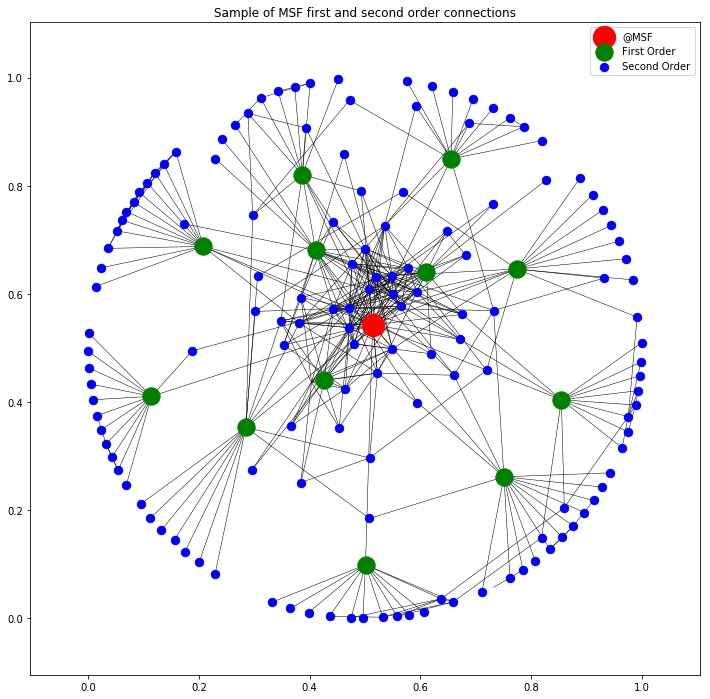

In [607]:
# Visualize the graph
# Altough this is not asked in the homework, we where interested
# to actually see the resulting graph from our measurements
# It is also a good way to see the links and the network and sometimes
# to visually solve bugs
network_graph = nx.Graph(network)
pos=nx.spring_layout(network_graph, iterations=100)
plt.figure(1, figsize=(12,12))
plt.title("Sample of MSF first and second order connections")
nx.draw_networkx_nodes(network_graph,pos, nodelist=[user_id],
                       node_size=500, node_color='r',
                       label="@MSF")
nx.draw_networkx_nodes(network_graph,pos, nodelist=list(first_nodes),
                       node_size=300, node_color='g',
                      label="First Order")
nx.draw_networkx_nodes(network_graph,pos, nodelist=list(second_nodes),
                       node_size=70, node_color='b',
                      label="Second Order")
nx.draw_networkx_edges(network_graph,pos, width=0.5)
plt.legend()
plt.show()

# 2. Discover some of the properties of the collected network

## 2.1 Adjacency matrix

Congradulations! You have now created a dictionary that describes a real Twitter network!
We now want to transform this dictionary into the adjacency (or weight) matrix that you learned about in your first class. 

In [559]:
W=np.zeros([len(all_nodes),len(all_nodes)], dtype=int)

In [565]:
for row in range(0,len(all_nodes)):
    for col in range(0,len(all_nodes)):
         # A node cannot be adjacent to itself
        if row is col:    
            W[row][col] = 0
        #Check if there's an edge connectiong the nodes
        elif (all_nodes[row] in network[all_nodes[col]]) or (all_nodes[col] in network[all_nodes[row]]):
            W[row][col] = 1
        else:
            W[row][col] = 0

Remember that a weight matrix should be symmetric. Check if it is:

In [566]:
np.nonzero(W-W.transpose())

(array([], dtype=int64), array([], dtype=int64))

**Question 1:**
It might happen that $W \neq W^{T} $ for some $(i,j)$. Explain why this might be the case.

**Your answer here:** It could have happened in the cases where a user doesn't let us check its contacts if we programmed differently. Indeed, if we used only the entry in the dictionary "network" associated with the node to populate the array, if the entry wouldn't contain a connection that is in the dictionary associated the other node, then there could be mismatch. Because we use both the dictionary entry for the node and the dictionary entry of its potential connection in the edge boolean detector, this case cannot happen.

Impose your weight matrix to be symmetric.

In [567]:
# Make W is symmetric
bigger = W.transpose() > W

In [568]:
W = W - W*bigger + W.transpose()*bigger

Plot the weight matrix of your collected network.

Hint: use `plt.spy()` to visualize a matrix.

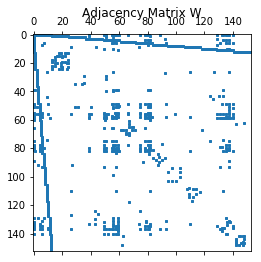

In [569]:
# your code here
plt.title('Adjacency Matrix W')
plt.spy(W,markersize=2)

**Question 2:**
What is the maximum number of links $L_{max}$ in a network with $N$ nodes (where $N$ is the number of nodes in your collected network)? How many links $L$ are there in your collected network? Comment on how $L$ and $L_{max}$ compare.

**Your answer here:**
* Maximum number of links : the maximum number of links is attained when every node is connected to every other node. It is given by:
$$ L_{max} = (N*N-1) / 2$$
N-1 used to remove the diagonal from the count

In [570]:
Lmax=len(W)*(len(W)-1) /2
print(Lmax)

11628.0


* How many links in collected network:
We simply have to make the sum of the links in the network and divide it by two 
$$ L_W = \frac{1}{2} \sum_{i=0}^{len(W)-1}\sum_{j=0}^{len(W[0])-1}W(i)(j)$$

In [571]:
LW = np.sum(W)/2
print("There are {} links in the collected network".format(LW))

There are 396.0 links in the collected network


* Comment on how L and Lmax compare: 
We can see that L is over an order of magnitude smaller than $L_{max}$. This means that we have a very sparse graph. This is indeed the case as we have seen from the adjacent matrix.

## 2.2 Degrees distribution

Plot a histogram of the degree distribution. 

In [572]:
p = [np.sum(W[index]) for index in range(0, len(W))]

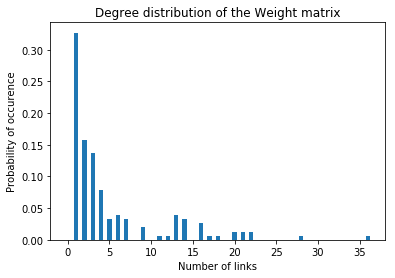

In [573]:
plt.hist(p, bins=range(0,np.amax(p)+2), normed=True, rwidth = 0.5, align='left')
plt.title("Degree distribution of the Weight matrix")
plt.xlabel("Number of links")
plt.ylabel("Probability of occurence")
plt.show()

**Question 3:** Comment on the plot. What do you observe? Would you expect a similar degree disribution in the complete Twitter network?

We can see that there's a high proportion of nodes that have a small number of links. Then, we see that a decent proportion of nodes are in the middle range, from 10 to 20 links. Most of those nodes must be first order connections, but not all of them, because we can see that there's too many. Therefore, some second order nodes are hubs in our dataset. We can imagine that other MSF pages would act this way, since the people following the international page are likely also following other MSF pages and MSF pages are likely following each other. Finally, we can see that we have nodes that are major hubs (>20 links). Lets get more information about those hubs, because we can:

In [576]:
# Extract the big hub users from the weight matrice
# and get their profile information from twitter
big_hub_list = [row for row in range(0,len(W)) if np.sum(W[row]) > 20]
print(big_hub_list)

big_hub_users = [api.get_user(all_nodes[user]) for user in big_hub_list]

[0, 6, 56, 58, 59, 82]


In [582]:
# Create a formatted output for the information obtained
print("The user creating big hub in the graph are:\n")
for pos, user in enumerate(big_hub_users):
    print("ID {}\nUser: {}\nNumber of links:{}\nFirst order:{}\nDescription: {}\n\n".format(user.id,
                                                                            user.screen_name,
                                                                            np.sum(W[big_hub_list[pos]]),
                                                                            all_nodes[big_hub_list[pos]] in first_nodes,
                                                                            user.description))
    

The user creating big hub in the graph are:

ID 2195671183
User: MSF
Number of links:36
First order:False
Description: Médecins Sans Frontières (MSF) is an international, independent, medical humanitarian organisation.


ID 300759553
User: MPeremans
Number of links:22
First order:True
Description: 


ID 14950946
User: jtcone1977
Number of links:28
First order:False
Description: Executive Director, Doctors w/o Borders @MSF_USA. Knowledge is knowing that we cannot know--Emerson. @FandMCollege & @TNGOInitiative Alum


ID 1410948991
User: CVanNespen
Number of links:21
First order:False
Description: Freelance #journalist #MSF #humanitarian #international #NGO #media #migration #migrants. Views are mine. RT ≠ endorsement.


ID 17774661
User: Tammamo
Number of links:22
First order:False
Description: Syrian physician, Deputy Medical Director, Doctors w/o Borders @MSF Switzerland. Tweets my own!


ID 14755217
User: MSF_france
Number of links:21
First order:False
Description: COMPTE OFFICIEL de 

We can see from the cell above that the resulting big nodes are generally not first order connections. In fact, the only one is MPeremans whose connections might have been inflated by the fact that its a first nodes. It is interesting to see that all the big hubs have direct link with MSF in their profile description. Therefore, there's a clear correlation with being a big second order hub and having an important link with MSF.

The degree distribution we obtain is actually very artificial, because we use a very limited scope for the links between nodes.
Because of this, it is possible that we under-estimate the connections for many nodes in the graph. 

The generic classification we obtained for nodes (small number of links, medium number of links, high number of links), with a decreasing amount of members for each subsequent node is likely a good representation of what happens on twitter, especially if we consider nodes of a region that are close to a central node, like we did here. Indeed, many small accounts must exist that have small amounts of connections and that are just superficially connected to the central nodes. Then, some account have medium-range links, they have a definite presence in the cluster, but are not popular enough to have many contacts. Finally, some account are hubs regarding a subject: if you are interested in MSF, you will most likely follow MSF and their close partners. Because those nodes have such an intricate link, they'll all be connected together which will create clusters of nodes interested by a subject.

Obviously, in the whole Twitter network, the picture would be more complex because various clusters could be linked together and have even more varying degrees of popularity attached to them. 

## 2.3 Average degree

Calculate the average degree of your collected network.

In [585]:
d_avg = np.average(p)
print("Average degree: {}".format(d_avg))

Average degree: 5.176470588235294


## 2.4 Diameter of the collected network

**Question 4:** What is the diameter of the collected network? Please justify.

Our graph originates with the twitter page of the "user_id" user, we will call the associated node "Source". Every nodes is added with a link to the Source node or with a link to a node that has a link to the Source node. Because of this, the longest path from any node to the source is 2. Even without seeing the actual graph, we can infer from this that the diameter of the network has an upper boundary of 4: any two pair of nodes that we will connect together have a maximum distance to the Source of 2 and therefore a maximum distance between them of 4.

To find out if this is the case in our graph, we can simply check if two second order nodes that have no other connections than their first order node and for which the first order nodes are not connection. This is sufficient to prove that the maximum distance is 4.

In [587]:
# Prove or disprove the presence of a node at distance 4
lonely_nodes = []
found_distance_four = False
for node in second_nodes:
    # Find all nodes who have only a parent as a connection
    if len(network[node]) is 1:
        lonely_nodes.append(node)
for node in lonely_nodes:
    if found_distance_four:
        break
    for other_node in lonely_nodes:
        # Check if they have the same parent
        if not (network[node][0] in network[other_node]):
            # Check if their parents are connected
            if not (network[node][0] in network[other_node] or network[other_node][0] in network[node]):
                print("Found two nodes at distance 4, node {} and node {}".format(node, other_node))
                print("Diameter must be 4")
                found_distance_four = True
                break
if not found_distance_four:
    print("No nodes at distance four, diameter is most likely 3")

Found two nodes at distance 4, node 15262969 and node 1598429348
Diameter must be 4


## 2.5 Pruning the collected network

You might notice that some nodes have very few connections and hence our matrix is very sparse. Prune the collected network so that you keep only the nodes that have a degree that is greater than the average degree and plot the new adjacency matrix.

In [588]:
# Create a new version of the all_nodes array with only the
# nodes that contain more than the average of connections
pruned_all_nodes = [node for node in all_nodes \
                    if (len(network[node]) > d_avg)]
Wpruned = np.zeros([len(pruned_all_nodes),len(pruned_all_nodes)], dtype=int)                      
for row in range(0,len(pruned_all_nodes)):
    for col in range(0,len(pruned_all_nodes)):
         # A node cannot be adjacent to itself
        if row is col:    
            Wpruned[row][col] = 0
        #Check if there's an edge connectiong the nodes
        elif (pruned_all_nodes[row] in network[pruned_all_nodes[col]]) \
                        or (pruned_all_nodes[col] in network[all_nodes[row]]):
            Wpruned[row][col] = 1
        else:
            Wpruned[row][col] = 0

In [589]:
# Make W is symmetric
bigger = Wpruned.transpose() > Wpruned

In [590]:
Wpruned = Wpruned - Wpruned*bigger + Wpruned.transpose()*bigger

In [591]:
# Some nodes might end up with no connections in the adjacency Matrix
# This is due to all their connections having their connections deleted
# Remove the rows and columns associated with those nodes
# Note: this doesn't happen with every measurements
rows_to_del = np.where(~Wpruned.any(axis=1))[0]
cols_to_del = np.where(~Wpruned.any(axis=0))[0]
print("Rows to delete:\t\t{}\nColumns to delete:\t{}".format(rows_to_del, cols_to_del))

Wpruned = np.delete(Wpruned,rows_to_del, axis=1)
Wpruned = np.delete(Wpruned,cols_to_del, axis=0)
#print(Wpruned)

Rows to delete:		[]
Columns to delete:	[]


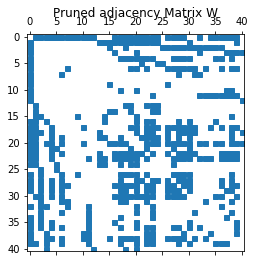

In [592]:
# Note: Some node don't have the proper number of links because they were
#       linked to node that have been removed
plt.spy(Wpruned, markersize=5)
plt.title('Pruned adjacency Matrix W');

In [598]:
pruned_network = dict((k,v) for k,v in network.items() if k in pruned_all_nodes)
for k in pruned_network.keys():
    pruned_network[k] = [values for values in pruned_network[k] if values in pruned_all_nodes]

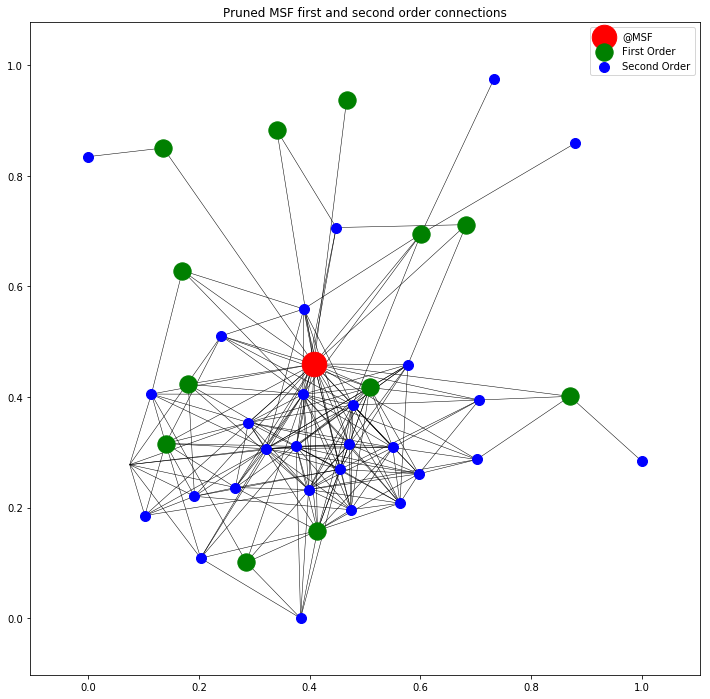

In [611]:
# Visualize the graph
# We superpose it over the results from the previous graph to show which 
# nodes made it through (shown in cyan)
pruned_network_graph= nx.Graph(pruned_network)
pos=nx.spring_layout(pruned_network_graph, iterations=150)
plt.figure(2, figsize=(12,12))
plt.title("Pruned MSF first and second order connections")
nx.draw_networkx_nodes(pruned_network_graph,pos, nodelist=[user_id],
                       node_size=600, node_color='r',
                       label="@MSF")
nx.draw_networkx_nodes(pruned_network_graph,pos, nodelist=[node for node in pruned_all_nodes if node in first_nodes],
                       node_size=300, node_color='g',
                       label="First Order")
nx.draw_networkx_nodes(pruned_network_graph,pos, nodelist=[node for node in pruned_all_nodes if node in second_nodes],
                       node_size=100, node_color='b',
                       label="Second Order")
nx.draw_networkx_edges(pruned_network_graph,pos,width=0.5)
plt.legend()
plt.show()